In [9]:
import re #pacchetto per espressioni regolari
import os #pacchetto per muoversi nelle cartelle
import sys
sys.path.append('..')  # Add parent directory to the Python path
from utils.helpers import *
import pandas as pd


In [2]:
train_path = 'data/training.txt'
test_path = 'data/test.txt'
out_dir = 'data/profiling_input'

In [3]:
# Necessario etichettare il blind test

# Read gold.txt file and extract gender values
with open("data/gold.txt", "r") as gold_file:
    gold_data = gold_file.readlines()

# Create a dictionary to store the gender values
gender_dict = {}
for line in gold_data:
    line_parts = line.strip().split("\t")
    doc_id = line_parts[0]
    gender = line_parts[1]
    gender_dict[doc_id] = gender

# Read test.txt file and replace "?" with gender values
with open("data/test.txt", "r") as test_file:
    test_data = test_file.readlines()

# Replace "?" with gender values from gold.txt
updated_test_data = []
for line in test_data:
    if "?" in line:
        doc_ids = re.findall(r'id="(.*?)"', line)
        if doc_ids:  # Check if any doc_ids were found
            doc_id = doc_ids[0]  # Take the first doc_id found
            gender = gender_dict.get(doc_id, "?")
            updated_line = line.replace("?", gender)
            updated_test_data.append(updated_line)
        else:
            updated_test_data.append(line)  # If no doc_id found, append line unchanged
    else:
        updated_test_data.append(line)

# Write the updated test data to a new file
with open("data/test.txt", "w") as updated_test_file:
    updated_test_file.writelines(updated_test_data)

In [10]:
for file_path in [train_path, test_path]:
    split = get_split(file_path)

    for line in open(file_path, 'r'):
        line = line.strip() # rimuoviamo eventuali spazi e ritorni a capo

        if '<doc id="' in line:    # troviamo un nuovo documento
            doc_id, genre, gender = get_doc_info(line)
            out_file_name = f'{split}#{doc_id}#{genre}#{gender}.txt'
            out_file_path = os.path.join(out_dir, out_file_name)
            user_post = []

        elif '</doc>' in line:     # fine dell'utente
            with open(out_file_path, 'w', encoding="utf-8") as out_file:
                for post in user_post:
                    out_file.write(post)
                    out_file.write('\n')

        elif line != '':  # siamo in corrispondenza del testo di un post
            user_post.append(line)

# Utilizzo del profiling ud

In [2]:
profiling_output_path = 'data/profiling_output/11325.csv'


In [10]:
features_names, documents_info, features = load_dataset(profiling_output_path)


In [11]:
print(f'Numero features: {len(features_names)}')
print('\nLista features:')
print(features_names[:10])

Numero features: 138

Lista features:
['n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'ttr_lemma_chunks_100', 'ttr_lemma_chunks_200', 'ttr_form_chunks_100', 'ttr_form_chunks_200', 'upos_dist_ADJ', 'upos_dist_ADP']


In [12]:
labels = create_label_list(documents_info)


In [13]:
len(labels)

400

In [14]:
train_features, train_labels, test_features, test_labels = train_test_split(documents_info, features, labels)

print('Documenti training set:', len(train_features), len(train_labels))
print('Documenti test set:', len(test_features), len(test_labels))

Documenti training set: 200 200
Documenti test set: 200 200


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_features)
X_test = scaler.transform(test_features)


In [18]:
# Conversione in DataFrame senza specificare i nomi delle colonne
save_df(X_train, train_labels, "children")
save_df(X_test, test_labels, "children_test")

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define the parameter grid to search through
param_grid = {
    'C': [0.1, 0.01, 0.001, 0.0001],  # Regularization parameter
    'dual': [True, False]
}

# Initialize SVM with linear kernel
svc = LinearSVC()

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, refit=True)

# Fit the grid search to your data
grid_search.fit(X_train, train_labels)

# Get mean test scores across folds
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Print the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)

Best parameters found: {'C': 0.001, 'dual': True}
Best score found: 0.5900000000000001


In [43]:
# Get the best estimator (model) found by grid search
best_model = grid_search.best_estimator_

# Now, you can use this best_model to make predictions on new data
# For example, if you have new data X_new, you can predict its labels as follows:
predictions = best_model.predict(X_test)

In [44]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
test_predictions = predictions
print(classification_report(test_labels, test_predictions, zero_division=0)) # output_dict=True

              precision    recall  f1-score   support

           F       0.53      0.64      0.58       100
           M       0.54      0.43      0.48       100

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.54      0.54      0.53       200



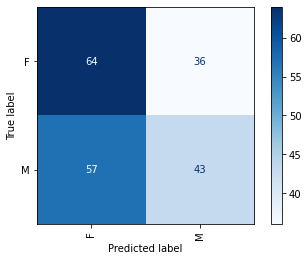

In [45]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', cmap='Blues');

In [51]:
coefs = best_model.coef_ # ndarray of shape (1, n_features) if n_classes == 2 else (n_classes, n_features)
coefs.shape

(1, 138)

In [ ]:
svc=best_model

Feature importance class F


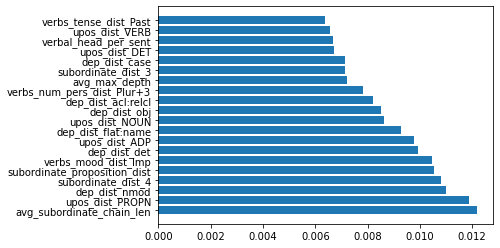

In [ ]:
import matplotlib.pyplot as plt

# Assuming `coefs` is your coefficients obtained from the SVM model
# Assuming `features_names` is a list containing the names of your features
idx = 0
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

num_to_plot = 15
print(f'Feature importance')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.show()
